# Theory Approximations
This runs through derivation of theory, one approximation at a time.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import decompose_temp_adiabat_anomaly, get_temp_adiabat, get_theory_prefactor_terms, \
    get_delta_temp_quant_theory_final, mse_mod_anom_change_ft_expansion, mse_mod_change_surf_expansion, get_delta_temp_quant_theory_final2, get_scaling_factor_theory
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-06-06 17:38:36,438 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'klzbs', 'convflag']        # only keep variables required to compute relative humidity and MSE


use_time_start = 360*2
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)

# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
# refer to bucket model with vegetation as bucket
# Don't include actual bucket, as looks very similar to bucket with vegetation param
# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'
exp_dir = 'tau_sweep/aquaplanet/depth=1/'

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']

kappa_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_kappa = len(kappa_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = isca_tools.load_dataset(exp_dir + kappa_names[j]).sel(time=slice(use_time_start, np.inf))[var_keep]
        
        ds += [ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')]      # only keep the surface and free troposphere values
        namelist = isca_tools.load_namelist(exp_dir + kappa_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        pbar.update(1)
        
pfull = ds_use.pfull
ind_surf = 0
ind_ft = 1
p_surface = float(ds[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
n_pressure = ds[0].pfull.size
lnp_const = R * np.log(p_surface/pressure_ft_actual)/2      # for modified MSE calculation

100%|██████████| 2/2 [00:03<00:00,  1.84s/it]


## Get datasets
Get one dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the all or just tbe summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [4]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, kappa_names[0], 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land
    
    if save_fig or save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [5]:
# Load in across all latitudes, for given season

# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# lat_max = 90

# Chose whether to only consider summer days or consider all days
# season = 'all'
season = 'summer'
# season = 'winter'
if season == 'summer':
    if region == 'tropics':
        season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}   
    else:
        season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    if region == 'tropics':
        season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]} 

lat_use_ind = np.where((np.abs(ds[0].lat) <= lat_max) & (np.abs(ds[0].lat) >= lat_min))[0]
n_lat = len(lat_use_ind)
lat_weights = np.cos(np.deg2rad(ds[0].lat))[lat_use_ind]

# Whether to do taylor expansion about mean over just land or mean over whole planet
mean_method = 'land'
# mean_method = 'all'

temp_mean = np.zeros((n_kappa, n_pressure, n_lat))
r_mean = np.zeros((n_kappa, n_lat))          # compute mean rh as mean over rh on each day
z_mean = np.zeros((n_kappa, n_pressure, n_lat))

ds_all = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds[j].isel(lat=lat_use_ind)   # only keep latitudes being used to save memory
        
        if is_land_data:
            # if not aquaplanet, then is land and only consider land longitudes
            ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])
        
        if season == 'summer':
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(0, 90))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-90, 0)) 
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        
        if mean_method == 'all':
            ds_use = ds[j].sel(time=slice(use_time_start, np.inf)).isel(lat=lat_use_ind)
            ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        elif mean_method != 'land':
            raise ValueError(f'Mean method is {mean_method} which is not valid.')
        temp_mean[j] = ds_use.temp.mean(dim='lon_time')
        z_mean[j] = ds_use.height.mean(dim='lon_time')
        rh_use = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
        r_mean[j] = rh_use.mean(dim='lon_time')
        pbar.update(1)
sphum_mean = r_mean * sphum_sat(temp_mean[:, ind_surf], p_surface)       # compute sphum_mean from r_mean

100%|██████████| 2/2 [00:20<00:00, 10.39s/it]


In [6]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
percentile_label = 'Temperature percentile, $x$'

# Days must have klzb < thresh and convflag > thresh to be considered convecting.
klzb_thresh = 13
convflag_thresh = 1

# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
# relative humidity as function of temp quantile not temp quantile
r_quant3 = np.zeros((n_kappa, n_lat, n_quant))
z_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
convflag_quant3 = np.zeros((n_kappa, n_lat, n_quant))
klzbs_quant3 = np.zeros((n_kappa, n_lat, n_quant))
convfract_quant3 = np.zeros((n_kappa, n_lat, n_quant))            # record fraction of days convecting

with tqdm(total=n_kappa*n_quant*n_lat, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds_all[j]
        temp_quant3[j] = ds_use.temp.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose('pfull', 'lat', 'quantile')
        rh_use = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
        is_convecting = np.logical_and(ds_use.klzbs<klzb_thresh, ds_use.convflag > convflag_thresh)
        for k in range(n_lat):
            for q, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds_use.temp[ind_surf, k], quant, 0.5, 0.5)
                z_quant3[j, :, k, q] = ds_use.height[:, k, use_ind].mean(dim='lon_time')
                r_quant3[j, k, q] = rh_use[k, use_ind].mean(dim='lon_time')
                convflag_quant3[j, k, q] = ds_use.convflag[k, use_ind].mean(dim='lon_time')
                klzbs_quant3[j, k, q] = ds_use.klzbs[k, use_ind].mean(dim='lon_time')
                convfract_quant3[j, k, q] = np.sum(is_convecting[k, use_ind])/is_convecting[k, use_ind].size
                pbar.update(1)
sphum_quant3 = sphum_sat(temp_quant3[:, ind_surf], p_surface) * r_quant3             # compute specific humidity from relative humidity
r_anom = r_quant3 - r_mean[:, :, np.newaxis]
temp_anom = temp_quant3 - temp_mean[:, :, :, np.newaxis]

100%|██████████| 2772/2772 [00:17<00:00, 158.21it/s]


In [7]:
# temp_adiabat_anom = np.zeros((n_kappa, n_lat, n_quant))
# temp_ce_mean = np.zeros((n_kappa, n_lat))
# temp_ce_quant = np.zeros((n_kappa, n_lat, n_quant))
# temp_ft_anom = np.zeros((n_kappa, n_lat, n_quant))
# temp_adiabat_mean = np.zeros((n_kappa, n_lat))
# for j in range(n_lat):
#     temp_adiabat_anom[:, j], temp_ce_mean[:, j], temp_ce_quant[:, j], temp_ft_anom[:, j] = \
#         decompose_temp_adiabat_anomaly(temp_mean[:, ind_surf, j], temp_quant3[:, ind_surf, j], sphum_mean[:, j], 
#                                        sphum_quant3[:, j], temp_mean[:, ind_ft, j], temp_quant3[:, ind_ft, j], 
#                                        p_surface, pressure_ft_actual)
#     for i in range(n_kappa):
#         temp_adiabat_mean[i, j] = get_temp_adiabat(temp_mean[i, ind_surf, j], sphum_mean[i, j], p_surface, pressure_ft_actual)
# temp_ce_mean_change = temp_ce_mean[1] - temp_ce_mean[0]
# temp_ce_quant_change = temp_ce_quant[1] - temp_ce_quant[0]
# temp_ft_anom_change = temp_ft_anom[1] - temp_ft_anom[0]
# z_ft_mod_anom = (z_quant3[:, ind_ft] - z_mean[:, ind_ft][:, :, np.newaxis]) * g / lnp_const 
# temp_adiabat_anom_quant3_z_form = z_ft_mod_anom + np.expand_dims(temp_ce_mean, axis=-1) - temp_ce_quant

In [8]:
# Surface MSE
mse_quant3 = moist_static_energy(temp_quant3[:, ind_surf], sphum_quant3, z_quant3[:, ind_surf])
mse_mean = moist_static_energy(temp_mean[:, ind_surf], sphum_mean, z_mean[:, ind_surf])
# mse_mod_quant3 = moist_static_energy(temp_quant3[:, ind_surf], sphum_quant3, height=0, 
#                                         c_p_const=c_p - lnp_const)
# mse_mod_mean = moist_static_energy(temp_mean[:, ind_surf], sphum_mean, height=0, c_p_const=c_p - lnp_const)

# Free troposphere MSE
mse_ft_sat_quant3 = moist_static_energy(temp_quant3[:, ind_ft], sphum_sat(temp_quant3[:, ind_ft], pressure_ft_actual), z_quant3[:, ind_ft])
mse_ft_sat_mean = moist_static_energy(temp_mean[:, ind_ft], sphum_sat(temp_mean[:, ind_ft], pressure_ft_actual), 
                                      z_mean[:, ind_ft])
mse_mod_quant3 = mse_ft_sat_quant3 - (lnp_const * temp_quant3[:, ind_surf] + g * z_quant3[:, ind_surf])/1000
mse_mod_mean = mse_ft_sat_mean - (lnp_const * temp_mean[:, ind_surf] + g * z_mean[:, ind_surf])/1000

# CQE indicator
epsilon_quant3 = mse_quant3 - mse_ft_sat_quant3
epsilon_mean = mse_mean - mse_ft_sat_mean
epsilon_anom = epsilon_quant3 - epsilon_mean[:, :, np.newaxis]

## Approximation 0 - $z$ Relation
A crucial aspect to this theory is relating the geopotential height $z_{FT}$ to near-surface temperature $T$ and free troposphere temperature $T_{FT}$.

We start with two equations, from Zhang 2023. The first combines hydrostatic balance and the ideal gas law. The second assumes a constant lapse rate, $\Gamma$, for integration processes.

$d\ln p = -\frac{g}{RT(p)}dz$;      $z(p) - z_s = \frac{T_s - T(p)}{\Gamma}$

Combining the two, we get $d\ln p = \frac{g}{R\Gamma}d\ln T$.

Integrating between the free troposphere at 500hPa and surface at 1000hPa, we get:
$\ln(\frac{1000}{500}) = \ln 2 = \frac{g}{R\Gamma}\ln(\frac{T_s}{T_{500}})$ or $\frac{1}{\Gamma} = \frac{R\ln 2}{g\ln(\frac{T_s}{T_{500}})}$

We also have the $z$ equation applied at 500hPa: $z_{500} - z_s = \frac{T_s - T_{500}}{\Gamma}$. Combining the two, we get:
$z_{500} - z_s \approx \frac{R\ln 2(T_s - T_{500})}{g\ln(\frac{T_s}{T_{500}})}$

We can re-write the denominator in $\ln(1+x)$ form as $\ln(1+\frac{T_s-T_{500}}{T_{500}})$. Here $x=\frac{T_s-T_{500}}{T_{500}}$ and is small. Max value in tropics is about 0.15. 

The taylor series is $\frac{1}{\ln(1+x)} \approx \frac{1}{x} + \frac{1}{2} - \frac{x}{12} + ...$. Because $x$ is small, I propose keeping just the first two terms. In which case, we get:

$z_{500} - z_s \approx \frac{R\ln 2(T_s - T_{500})}{g}(\frac{T_{500}}{T_s-T_{500}} + \frac{1}{2}) = \frac{R\ln 2}{2g}(T_s + T_{500})$

The plots below shows that the taylor approximation is pretty accurate, but they are both bad approximations for the actual geopotential height.

In [9]:
def get_z_theory(temp_surf, temp_ft, taylor=True, pressure_surf=p_surface, pressure_ft=pressure_ft_actual):
    lnp_prefactor = R * np.log(pressure_surf/pressure_ft) / g
    if taylor:
        return lnp_prefactor/2 * (temp_surf + temp_ft)
    else:
        return lnp_prefactor * (temp_surf - temp_ft) / np.log(temp_surf/temp_ft)


z_anom = z_quant3 - z_mean[:, :, :, np.newaxis]
z_theory_quant3 = {key: np.zeros((n_kappa, n_lat, n_quant)) for key in ['full', 'taylor']}
z_theory_mean = {key: np.zeros((n_kappa, n_lat)) for key in ['full', 'taylor']}
for i in range(n_kappa):
    for key in z_theory_quant3:
        z_theory_quant3[key][i] = get_z_theory(temp_quant3[i, ind_surf], temp_quant3[i, ind_ft], True if key=='taylor' else False)
        z_theory_mean[key][i] = get_z_theory(temp_mean[i, ind_surf], temp_mean[i, ind_ft], True if key=='taylor' else False)

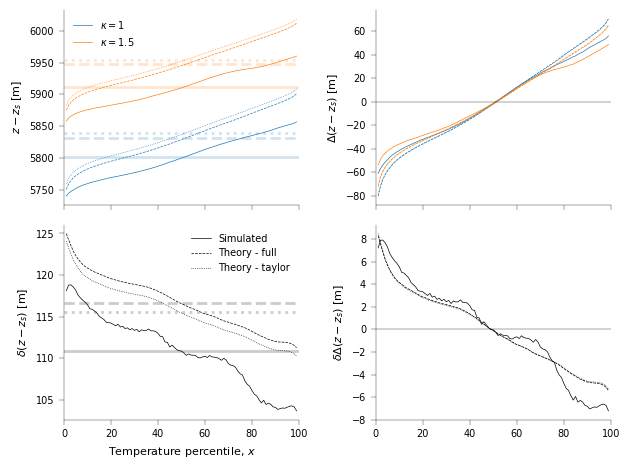

In [10]:
save_z_ft_fig = False
fig, ax = plt.subplots(2,2, figsize=(2*width['one_col'], 2*width['one_col']/ar), sharex=True)
linestyles_use = {'full': '--', 'taylor': ':'}
for i in range(n_kappa):
    ax[0, 0].plot(quant_plot, 
               np.average(z_quant3[i, ind_ft] - z_quant3[i, ind_surf], axis=0, weights=lat_weights), color=default_colors[i],
               label=f'$\\kappa={tau_lw[i]}$')
    ax[0, 0].axhline(np.average(z_mean[i, ind_ft]-z_mean[i, ind_surf], axis=0, weights=lat_weights), color=default_colors[i], lw=2, alpha=0.2)
    for key in z_theory_quant3:
        ax[0, 0].plot(quant_plot, 
                   np.average(z_theory_quant3[key][i], axis=0, weights=lat_weights), color=default_colors[i], 
                   linestyle=linestyles_use[key])
        ax[0, 0].axhline(np.average(z_theory_mean[key][i], axis=0, weights=lat_weights), color=default_colors[i], 
                      linestyle=linestyles_use[key], lw=2, alpha=0.2)
ax[1, 0].plot(quant_plot, 
           np.average(np.diff(z_quant3[:, ind_ft] - z_quant3[:, ind_surf], axis=0)[0], axis=0, weights=lat_weights), color='k',
           label='Simulated')
ax[1, 0].axhline(np.average(np.diff(z_mean[:, ind_ft]-z_mean[:, ind_surf], axis=0)[0], axis=0, weights=lat_weights), 
              color='k', lw=2, alpha=0.2)
for key in z_theory_quant3:
    ax[1, 0].plot(quant_plot, 
                   np.average(z_theory_quant3[key][1]-z_theory_quant3[key][0], axis=0, weights=lat_weights), 
               color='k', linestyle=linestyles_use[key], label=f'Theory - {key}')
    ax[1, 0].axhline(np.average(z_theory_mean[key][1]-z_theory_mean[key][0], axis=0, weights=lat_weights), color='k', 
                  linestyle=linestyles_use[key], lw=2, alpha=0.2)

for i in range(n_kappa):
    ax[0, 1].plot(quant_plot, 
               np.average(z_anom[i, ind_ft] - z_anom[i, ind_surf], 
                          axis=0, weights=lat_weights), color=default_colors[i], label=f'$\\kappa={tau_lw[i]}$')
    for key in z_theory_quant3:
        ax[0, 1].plot(quant_plot, np.average(z_theory_quant3[key][i] - z_theory_mean[key][i][:, np.newaxis], axis=0, weights=lat_weights),
                      color=default_colors[i], linestyle=linestyles_use[key])
ax[1, 1].plot(quant_plot, 
           np.average(np.diff(z_anom[:, ind_ft] - z_anom[:, ind_surf], axis=0)[0], 
                      axis=0, weights=lat_weights), color='k')
for key in z_theory_quant3:
    ax[1, 1].plot(quant_plot, 
                   np.average(z_theory_quant3[key][1]-z_theory_quant3[key][0] - (z_theory_mean[key][1]-z_theory_mean[key][0])[:, np.newaxis], 
                              axis=0, weights=lat_weights), color='k', linestyle=linestyles_use[key], label=f'Theory - {key}') 

ax[0, 0].legend()
ax[1, 0].legend()
ax[0, 0].set_ylabel('$z-z_s$ [m]')
ax[0, 1].set_ylabel('$\Delta (z-z_s)$ [m]')
ax[1, 0].set_ylabel('$\delta (z-z_s)$ [m]')
ax[1, 1].set_ylabel('$\delta \Delta (z-z_s)$ [m]')
ax[1, 0].set_xlabel(percentile_label)
ax[0, 0].set_xlim(0, 100)
ax[0, 1].axhline(0, color='k', lw=ax_linewidth)
ax[1, 1].axhline(0, color='k', lw=ax_linewidth)
plt.tight_layout()
if save_fig or save_z_ft_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/land_z_ft_approx_{region}_{season}.pdf",
                                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [11]:
def scale_factor_theory_no_taylor_fit_func(scale_factor, temp_surf_mean, temp_surf_quant0, r_surf_mean, r_surf_quant, temp_ft_mean, temp_ft_quant, 
                                 z_surf_mean = None, z_surf_quant = None, z_ft_quant = None, z_ft_mean = None, epsilon_mean = None, 
                                 epsilon_quant = None, pressure_surf: float = p_surface, pressure_ft: float = pressure_ft_actual) -> float:
    # Finds scaling factor such that mse_s_quant - mse_s_mean = mse_ft_quant - mse_ft_mean + epsilon_quant - epsilon_mean
    # If z is not given, will assume z relation to temperature
    # If epsilon_mean not given, will assume CQE i.e. no change in epsilon anomaly with warming
    # Epsilon is in kJ/kg
    n_exp = len(r_surf_mean)
    temp_mean_change = temp_surf_mean[1] - temp_surf_mean[0]
    temp_quant_hot = temp_surf_quant0 + scale_factor * temp_mean_change
    
    if z_surf_mean is None:
        # Assume relation between z and temp
        z_surf_mean = np.zeros(n_exp)
        z_surf_quant = np.zeros(n_exp)
        z_ft_mean = np.zeros(n_exp)
        z_ft_quant = np.zeros(n_exp)
        c_p_const_surf = c_p - lnp_const
        c_p_const_ft = c_p + lnp_const
    else:
        c_p_const_surf = c_p
        c_p_const_ft = c_p
    
    mse_surf_quant_cold = moist_static_energy(temp_surf_quant0, r_surf_quant[0] * sphum_sat(temp_surf_quant0, pressure_surf), z_surf_quant[0],
                                              c_p_const=c_p_const_surf)
    mse_surf_quant_hot = moist_static_energy(temp_quant_hot, r_surf_quant[1] * sphum_sat(temp_quant_hot, pressure_surf), z_surf_quant[1], 
                                             c_p_const=c_p_const_surf)
    mse_surf_mean = [moist_static_energy(temp_surf_mean[i], r_surf_mean[i] * sphum_sat(temp_surf_mean[i], pressure_surf), z_surf_mean[i], 
                                         c_p_const=c_p_const_surf) 
                     for i in range(n_exp)]
    mse_ft_quant = [moist_static_energy(temp_ft_quant[i], sphum_sat(temp_ft_quant[i], pressure_ft), z_ft_quant[i], c_p_const=c_p_const_ft) 
                     for i in range(n_exp)]
    mse_ft_mean = [moist_static_energy(temp_ft_mean[i], sphum_sat(temp_ft_mean[i], pressure_ft), z_ft_mean[i], c_p_const=c_p_const_ft) 
                     for i in range(n_exp)]
    mse_surf_quant_change = mse_surf_quant_hot - mse_surf_quant_cold
    mse_surf_mean_change = mse_surf_mean[1] - mse_surf_mean[0]
    mse_ft_quant_change = mse_ft_quant[1] - mse_ft_quant[0]
    mse_ft_mean_change = mse_ft_mean[1] - mse_ft_mean[0]
    if epsilon_mean is not None:
        epsilon_quant_change = epsilon_quant[1] - epsilon_quant[0]
        epsilon_mean_change = epsilon_mean[1] - epsilon_mean[0]
    else:
        epsilon_quant_change = 0
        epsilon_mean_change = 0
    return mse_surf_quant_change - mse_surf_mean_change - (mse_ft_quant_change - mse_ft_mean_change) - (epsilon_quant_change - 
                                                                                                        epsilon_mean_change)

def scale_factor_theory_from_mse_anom_change_fit_func(scale_factor, temp_surf_mean, temp_surf_quant, r_surf_mean, r_surf_quant,
                                                      epsilon_mean, epsilon_quant, mse_mod_anom_change, pressure_surf: float = p_surface):
    # mse_mod_anom_change is in kJ/kg
    n_exp = len(r_surf_mean)
    temp_mean_change = temp_surf_mean[1] - temp_surf_mean[0]
    temp_quant_hot = temp_surf_quant[0] + scale_factor * temp_mean_change
    mse_mod_surf_quant_cold = moist_static_energy(temp_surf_quant[0], r_surf_quant[0] * sphum_sat(temp_surf_quant[0], pressure_surf), 0,
                                              c_p_const=c_p - lnp_const) - epsilon_quant[0]
    mse_mod_surf_quant_hot = moist_static_energy(temp_quant_hot, r_surf_quant[1] * sphum_sat(temp_quant_hot, pressure_surf), 0, 
                                             c_p_const=c_p - lnp_const) - epsilon_quant[1]
    mse_mod_surf_mean = [moist_static_energy(temp_surf_mean[i], r_surf_mean[i] * sphum_sat(temp_surf_mean[i], pressure_surf), 0, 
                                         c_p_const=c_p - lnp_const) - epsilon_mean[i]
                     for i in range(n_exp)]
    mse_mod_anom_change_from_sf = mse_mod_surf_quant_hot - mse_mod_surf_quant_cold - (mse_mod_surf_mean[1] - mse_mod_surf_mean[0])
    return mse_mod_anom_change_from_sf - mse_mod_anom_change

def scale_factor_theory_taylor_fit_func(scale_factor, temp_surf_mean, temp_surf_quant, r_surf_mean, r_surf_quant, epsilon_mean, epsilon_quant,
                                        mse_mod_anom_change_from_temp_ft, taylor_terms='linear', pressure_surf = p_surface, 
                                        pressure_ft=pressure_ft_actual, q_sat_s_linear_term_use=None, beta_s1_quant_use=None, 
                                        beta_s1_mean_use=None):
    # Makes same taylor series approximation for both ways of getting mse_anom_change
    # mse_mod_anom_change_from_temp_ft needs to be in kJ/kg
    temp_mean_change = temp_surf_mean[1] - temp_surf_mean[0]
    temp_surf_quant_use = np.asarray([temp_surf_quant[0], temp_surf_quant[0] + scale_factor * temp_mean_change], dtype=np.float64)
    
    sphum_mean = r_surf_mean * sphum_sat(temp_surf_mean, pressure_surf)
    sphum_quant = r_surf_quant * sphum_sat(temp_surf_quant_use, pressure_surf)
    
    mse_quant_change_from_temp_s = mse_mod_change_surf_expansion(temp_surf_quant_use[:, np.newaxis], sphum_quant[:, np.newaxis],
                                                                 epsilon_quant[:, np.newaxis], pressure_surf, pressure_ft, 
                                                                 taylor_terms=taylor_terms, q_sat_s_linear_term_use=q_sat_s_linear_term_use, 
                                                                 beta_s1_use=beta_s1_quant_use)[0]
    mse_mean_change_from_temp_s = mse_mod_change_surf_expansion(temp_surf_mean, sphum_mean, epsilon_mean,
                                                                pressure_surf, pressure_ft, taylor_terms=taylor_terms, 
                                                                beta_s1_use=beta_s1_mean_use)[0]
    mse_anom_change_from_temp_s = mse_quant_change_from_temp_s - mse_mean_change_from_temp_s
    return mse_mod_anom_change_from_temp_ft - mse_anom_change_from_temp_s

In [12]:
sf_denom = (temp_mean[1, ind_surf] - temp_mean[0, ind_surf])[:, np.newaxis]
sf_simulated = (temp_quant3[1, ind_surf] - temp_quant3[0, ind_surf]) / sf_denom
sf_theory = {'just_z': np.zeros((n_lat, n_quant))}
for i in range(n_lat):
    for j in range(n_quant):
        sf_theory['just_z'][i, j] = \
            scipy.optimize.fsolve(scale_factor_theory_no_taylor_fit_func, 1, 
                                  args=(temp_mean[:, ind_surf, i], temp_quant3[0, ind_surf, i, j], r_mean[:, i], 
                                        r_quant3[:, i, j], temp_mean[:, ind_ft, i], temp_quant3[:, ind_ft, i, j], 
                                        None, None, None, None, epsilon_mean[:, i], epsilon_quant3[:, i, j]))

mse_mod_anom = mse_mod_quant3 - mse_mod_mean[:, :, np.newaxis]
mse_mod_anom_change_simulated = mse_mod_anom[1] - mse_mod_anom[0]
q_sat_ft_anom_change = sphum_sat(temp_quant3[:, ind_ft], pressure_ft_actual) - sphum_sat(temp_mean[:, ind_ft], pressure_ft_actual)[:, :, np.newaxis]
q_sat_ft_anom_change = q_sat_ft_anom_change[1]-q_sat_ft_anom_change[0]
mse_mod_anom_change_theory = {'just_z': ((c_p+lnp_const) * (temp_anom[1]-temp_anom[0])[ind_ft] + L_v * q_sat_ft_anom_change)/1000}

(0.0, 100.0)

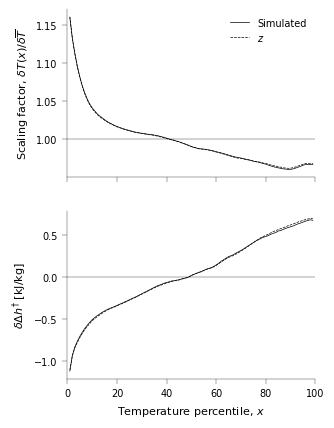

In [13]:
fig_approx0, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
ax[0].plot(quant_plot, np.average(sf_simulated, weights=lat_weights, axis=0), color='k',
           label='Simulated')
ax[0].plot(quant_plot, np.average(sf_theory['just_z'], weights=lat_weights, axis=0), color='k',
           label='$z$', linestyle='--')
ax[1].plot(quant_plot, np.average(mse_mod_anom_change_simulated, axis=0, weights=lat_weights), color='k')
ax[1].plot(quant_plot, np.average(mse_mod_anom_change_theory['just_z'], axis=0, weights=lat_weights), color='k', linestyle='--')
ax[0].legend()
ax[0].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
ax[1].set_ylabel('$\delta \Delta h^{\dagger}$ [kJ/kg]')
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)

# Free troposphere Expansion of $\delta \Delta h^{\dagger}$
## Approx FT1 - $\Delta h^{\dagger}$

In [14]:
_, _, _, beta_ft1, beta_ft2, beta_ft3 = get_theory_prefactor_terms(temp_mean[0, ind_ft], p_surface, pressure_ft_actual)
_, _, _, beta_ft1_hot, beta_ft2_hot, _ = get_theory_prefactor_terms(temp_mean[1, ind_ft], p_surface, pressure_ft_actual)
_, q_sat_s, alpha_s, beta_s1, beta_s2, _ = get_theory_prefactor_terms(temp_mean[0, ind_surf], p_surface, pressure_ft_actual, sphum_mean[0])

mse_mod_anom_theory = [beta_ft1[:, np.newaxis] * temp_anom[0, ind_ft], 
                       beta_ft1_hot[:, np.newaxis] * temp_anom[1, ind_ft]]
for i in range(n_kappa):
    mse_mod_anom_theory[i] = mse_mod_anom_theory[i]/1000
mse_mod_anom_change_theory['ft1'] =  mse_mod_anom_theory[1]-mse_mod_anom_theory[0]
sf_theory['ft1'] = np.zeros((n_lat, n_quant))
for i in range(n_lat):
    for j in range(n_quant):
        sf_theory['ft1'][i, j] = scipy.optimize.fsolve(scale_factor_theory_from_mse_anom_change_fit_func, 1, 
                                  args=(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i, j], r_mean[:, i], 
                                        r_quant3[:, i, j], epsilon_mean[:, i], epsilon_quant3[:, i, j], mse_mod_anom_change_theory['ft1'][i, j]))

(0.0, 100.0)

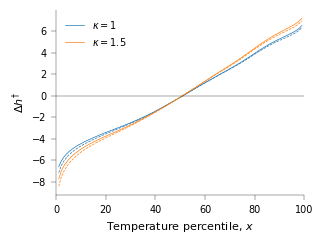

In [15]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_kappa):
    ax.plot(quant_plot, np.average(mse_mod_anom[i], weights=lat_weights, axis=0), color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
    ax.plot(quant_plot, np.average(mse_mod_anom_theory[i], weights=lat_weights, axis=0), color=default_colors[i], linestyle='--')
ax.legend()
ax.set_ylabel('$\Delta h^{\dagger}$')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)

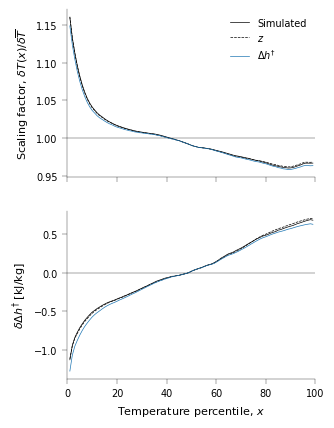

In [16]:
fig_approx1 = copy.deepcopy(fig_approx0)
ax = fig_approx1.axes
ax[0].plot(quant_plot, np.average(sf_theory['ft1'], weights=lat_weights, axis=0), color=default_colors[0],
           label='$\Delta h^{\dagger}$')
ax[1].plot(quant_plot, np.average(mse_mod_anom_change_theory['ft1'], weights=lat_weights, axis=0), color=default_colors[0])
ax[0].legend()
fig_approx1

## Approx FT2 - $\delta \Delta h^{\dagger}$
We take a linear change with warming of previous equation. This is quite a significant approximation - would be better for two simulations closer together in optical depth.

In [17]:
temp_ft_mean_change = temp_mean[1, ind_ft] - temp_mean[0, ind_ft]
mse_mod_anom_change_theory['ft2'] = beta_ft1[:, np.newaxis] * (temp_anom[1]-temp_anom[0])[ind_ft] + \
                                    (beta_ft2/temp_mean[0, ind_ft])[:, np.newaxis] * temp_anom[0, ind_ft] * temp_ft_mean_change[:, np.newaxis]
# mse_mod_anom_change_theory['ft2'] = mse_mod_anom_change_theory['ft2'] + (beta_ft2/temp_mean[0, ind_ft])[:, np.newaxis] * temp_ft_anom_change * temp_ft_mean_change[:, np.newaxis]
mse_mod_anom_change_theory['ft2'] = mse_mod_anom_change_theory['ft2']/1000
sf_theory['ft2'] = np.zeros((n_lat, n_quant))
for i in range(n_lat):
    for j in range(n_quant):
        sf_theory['ft2'][i, j] = scipy.optimize.fsolve(scale_factor_theory_from_mse_anom_change_fit_func, 1, 
                                  args=(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i, j], r_mean[:, i], 
                                        r_quant3[:, i, j], epsilon_mean[:, i], epsilon_quant3[:, i, j], mse_mod_anom_change_theory['ft2'][i, j]))

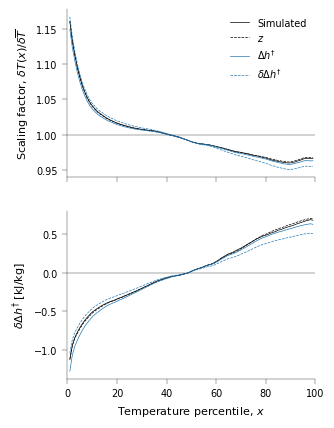

In [18]:
fig_approx2 = copy.deepcopy(fig_approx1)
ax = fig_approx2.axes
ax[0].plot(quant_plot, np.average(sf_theory['ft2'], weights=lat_weights, axis=0), color=default_colors[0], linestyle='--',
           label='$\delta \Delta h^{\dagger}$')
ax[1].plot(quant_plot, np.average(mse_mod_anom_change_theory['ft2'], weights=lat_weights, axis=0), color=default_colors[0], linestyle='--')
ax[0].legend()
fig_approx2

## Approx FT3 - $\delta \overline{T_{FT}}$
Use $\delta \overline{T_{FT}} \approx \frac{\delta \overline{h^{\dagger}}}{\beta_{FT1}}$ to link free tropospheric change to surface.

In [19]:
mse_mod_anom_change_theory['ft3'] = np.zeros((n_lat, n_quant))
sf_theory['ft3'] = np.zeros((n_lat, n_quant))
for i in range(n_lat):
    mse_mod_anom_change_theory['ft3'][i] = mse_mod_anom_change_ft_expansion(temp_mean[:, ind_ft, i], temp_quant3[:, ind_ft, i], p_surface,
                                                                     pressure_ft_actual, taylor_terms='linear')[0]
    for j in range(n_quant):
        sf_theory['ft3'][i, j] = scipy.optimize.fsolve(scale_factor_theory_from_mse_anom_change_fit_func, 1, 
                                  args=(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i, j], r_mean[:, i], 
                                        r_quant3[:, i, j], epsilon_mean[:, i], epsilon_quant3[:, i, j], mse_mod_anom_change_theory['ft3'][i, j]))

(0.0, 20.0)

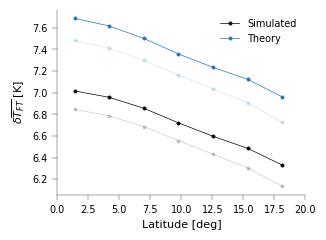

In [20]:
lat = ds[0].lat[lat_use_ind].to_numpy()
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(lat[lat>0], temp_ft_mean_change[lat>0], '-o', color='k', label='Simulated')
ax.plot(lat[lat>0], ((mse_mod_mean[1]-mse_mod_mean[0])*1000/beta_ft1)[lat>0], '-o', color=default_colors[0], label='Theory')
ax.plot(-lat[lat<0], temp_ft_mean_change[lat<0], '-o', color='k', alpha=0.2)
ax.plot(-lat[lat<0], ((mse_mod_mean[1]-mse_mod_mean[0])*1000/beta_ft1)[lat<0], '-o', color=default_colors[0], alpha=0.2)
ax.legend()
ax.set_ylabel('$\delta \overline{T_{FT}}$ [K]')
ax.set_xlabel('Latitude [deg]')
ax.set_xlim(lat_min, lat_max)

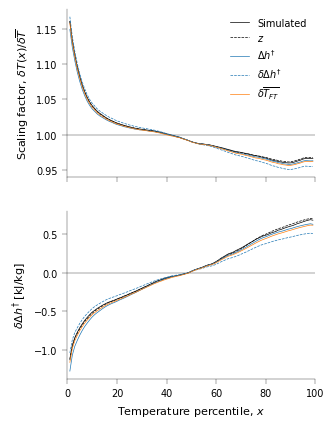

In [21]:
fig_approx3 = copy.deepcopy(fig_approx2)
ax = fig_approx3.axes
ax[0].plot(quant_plot, np.average(sf_theory['ft3'], weights=lat_weights, axis=0), color=default_colors[1],
           label='$\delta \overline{T_{FT}}$')
ax[1].plot(quant_plot, np.average(mse_mod_anom_change_theory['ft3'], weights=lat_weights, axis=0), color=default_colors[1])
ax[0].legend()
fig_approx3

## Approx FT4 - $\delta \overline{h^{\dagger}}$
Now, we expand $\delta \overline{h^{\dagger}}$ in terms of surface variables. We keep non-linear but not squared terms i.e.
$\delta \overline{h^{\dagger}} \approx \overline{\beta_{s1}}\delta \overline{T_s} + L_v \overline{q_s^*}\delta \overline{r_s} + 
L_v \overline{\alpha_s}\overline{q_s^*}\delta \overline{T_s}\delta \overline{r_s} - \delta \overline{\epsilon}$
This can be written as:
$\delta \overline{h^{\dagger}} \approx \overline{\beta_{s1}}(1+\overline{\mu}\frac{\delta\overline{r_s}}{\overline{r_s}})\delta \overline{T_s} + 
L_v \overline{q_s^*}\delta \overline{r_s} - \delta \overline{\epsilon}$

where $\mu = \frac{L_v \alpha_s q_s}{\beta_{s1}}$

In [22]:
mse_mod_mean_change_t_s_approx = {'ft4': np.zeros(n_lat)}
mse_mod_anom_change_theory['ft4'] = np.zeros((n_lat, n_quant))
sf_theory['ft4'] = np.zeros((n_lat, n_quant))
for i in range(n_lat):
    mse_mod_mean_change_t_s_approx['ft4'][i] = mse_mod_change_surf_expansion(temp_mean[:, ind_surf, i], sphum_mean[:, i], epsilon_mean[:, i],
                                                                  p_surface, pressure_ft_actual, taylor_terms='non_linear')[0]
    mse_mod_anom_change_theory['ft4'][i] = mse_mod_anom_change_ft_expansion(temp_mean[:, ind_ft, i], temp_quant3[:, ind_ft, i], p_surface,
                                                                            pressure_ft_actual, taylor_terms='linear', 
                                                                            mse_mod_mean_change=mse_mod_mean_change_t_s_approx['ft4'][i]*1000)[0]
    for j in range(n_quant):
        sf_theory['ft4'][i, j] = scipy.optimize.fsolve(scale_factor_theory_from_mse_anom_change_fit_func, 1, 
                                  args=(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i, j], r_mean[:, i], 
                                        r_quant3[:, i, j], epsilon_mean[:, i], epsilon_quant3[:, i, j], mse_mod_anom_change_theory['ft4'][i, j]))

(0.0, 20.0)

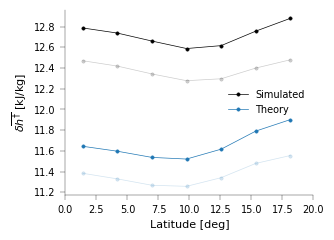

In [23]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(lat[lat>0], (mse_mod_mean[1]-mse_mod_mean[0])[lat>0], '-o', color='k', label='Simulated')
ax.plot(lat[lat>0], mse_mod_mean_change_t_s_approx['ft4'][lat>0], '-o', color=default_colors[0], label='Theory')
ax.plot(-lat[lat<0], (mse_mod_mean[1]-mse_mod_mean[0])[lat<0], '-o', color='k', alpha=0.2)
ax.plot(-lat[lat<0], mse_mod_mean_change_t_s_approx['ft4'][lat<0], '-o', color=default_colors[0], alpha=0.2)
ax.legend()
ax.set_ylabel('$\delta \overline{h^{\dagger}}$ [kJ/kg]')
ax.set_xlabel('Latitude [deg]')
ax.set_xlim(lat_min, lat_max)

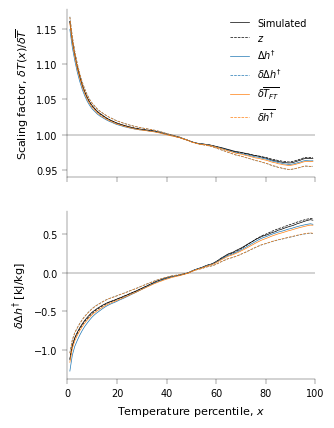

In [24]:
fig_approx4 = copy.deepcopy(fig_approx3)
ax = fig_approx4.axes
ax[0].plot(quant_plot, np.average(sf_theory['ft4'], weights=lat_weights, axis=0), color=default_colors[1], linestyle='--',
           label='$\delta \overline{h^{\dagger}}$')
ax[1].plot(quant_plot, np.average(mse_mod_anom_change_theory['ft4'], weights=lat_weights, axis=0), color=default_colors[1], linestyle='--')
ax[0].legend()
fig_approx4

## Approx FT5 - $\Delta T_{FT}$
We want to expand the climatological free tropospheric temperature anomaly in terms of surface quantities. Inverting Approx FT1 and neglecting small $\Delta h^{\dagger}(x)^2$ term, we have:

$\Delta T_{FT}(x) \approx \frac{\Delta h^{\dagger}(x)}{\beta_{FT1}}$

In [25]:
# temp_ft_anom0_theory = mse_mod_anom[0]*1000/beta_ft1[:, np.newaxis] - \
#                        (beta_ft2/(2*beta_ft1**3*temp_mean[0, ind_ft]))[:, np.newaxis] * (mse_mod_anom[0]*1000)**2
# temp_ft_anom0_squared_theory = (mse_mod_anom[0]*1000/beta_ft1[:, np.newaxis])**2
temp_ft_anom0_theory = {'ft5': mse_mod_anom[0]*1000/beta_ft1[:, np.newaxis]}
mse_mod_anom_change_theory['ft5'] = np.zeros((n_lat, n_quant))
sf_theory['ft5'] = np.zeros((n_lat, n_quant))
for i in range(n_lat):
    mse_mod_anom_change_theory['ft5'][i] = mse_mod_anom_change_ft_expansion(temp_mean[:, ind_ft, i], temp_quant3[:, ind_ft, i], p_surface,
                                                                            pressure_ft_actual, taylor_terms='linear', 
                                                                            mse_mod_mean_change=mse_mod_mean_change_t_s_approx['ft4'][i]*1000, 
                                                                            temp_ft_anom0=temp_ft_anom0_theory['ft5'][i])[0]
    for j in range(n_quant):
        sf_theory['ft5'][i, j] = scipy.optimize.fsolve(scale_factor_theory_from_mse_anom_change_fit_func, 1, 
                                  args=(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i, j], r_mean[:, i], 
                                        r_quant3[:, i, j], epsilon_mean[:, i], epsilon_quant3[:, i, j], mse_mod_anom_change_theory['ft5'][i, j]))

(0.0, 100.0)

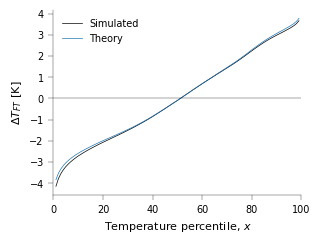

In [26]:
fig_temp_ft_anom, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax = [ax]
ax[0].plot(quant_plot, np.average(temp_anom[0, ind_ft], weights=lat_weights, axis=0), color='k', label='Simulated')
ax[0].plot(quant_plot, np.average(temp_ft_anom0_theory['ft5'], weights=lat_weights, axis=0), color=default_colors[0], label='Theory')
ax[0].legend()
ax[0].set_ylabel('$\Delta T_{FT}$ [K]')
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)

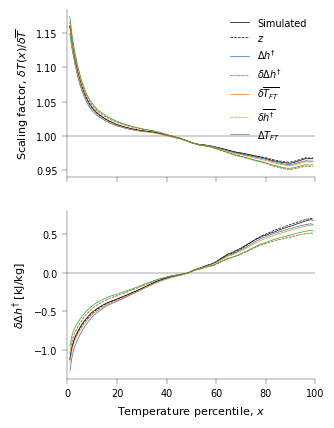

In [27]:
fig_approx5 = copy.deepcopy(fig_approx4)
ax = fig_approx5.axes
ax[0].plot(quant_plot, np.average(sf_theory['ft5'], weights=lat_weights, axis=0), color=default_colors[2],
           label='$\Delta T_{FT}$')
ax[1].plot(quant_plot, np.average(mse_mod_anom_change_theory['ft5'], weights=lat_weights, axis=0), color=default_colors[2])
ax[0].legend()
fig_approx5

## Approx FT6 - $\Delta h^{\dagger}$
Keeping non-linear terms, we have:

$\Delta h^{\dagger} \approx \overline{\beta_{s1}}(1+\overline{\mu}\frac{\Delta r_s}{\overline{r_s}})\Delta \overline{T_s} + 
L_v \overline{q_s^*}\Delta r_s - \Delta \epsilon$

The dashed green line in the scaling factor plot shows the final approximation for $\delta \Delta h^{\dagger}$ from a free tropospheric perspective:

$$\delta \Delta h^{\dagger} \approx \beta_{FT1} \delta \Delta T_{FT}(x) + 
\frac{\beta_{FT2}}{\beta_{FT1}^2\overline{T_{FT}}}\left(\overline{\beta_{s1}}(1+\overline{\mu}\frac{\Delta r_s}{\overline{r_s}})
\Delta \overline{T_s} + L_v \overline{q_s^*}\Delta r_s - \Delta \epsilon\right)
\left(\overline{\beta_{s1}}(1+\overline{\mu}\frac{\delta\overline{r_s}}{\overline{r_s}})\delta \overline{T_s} + 
L_v \overline{q_s^*}\delta \overline{r_s} - \delta \overline{\epsilon}\right)$$

In [28]:
mse_mod_anom0_theory = (beta_s1[:, np.newaxis] * temp_anom[0, ind_surf] + L_v * q_sat_s[:, np.newaxis] * r_anom[0])/1000 + \
                       L_v * (q_sat_s * alpha_s)[:, np.newaxis] * temp_anom[0, ind_surf]* r_anom[0]/1000  - epsilon_anom[0]
temp_ft_anom0_theory['ft6'] = mse_mod_anom0_theory*1000/beta_ft1[:, np.newaxis]
mse_mod_anom_change_theory['ft6'] = np.zeros((n_lat, n_quant))
sf_theory['ft6'] = np.zeros((n_lat, n_quant))
for i in range(n_lat):
    mse_mod_anom_change_theory['ft6'][i] = mse_mod_anom_change_ft_expansion(temp_mean[:, ind_ft, i], temp_quant3[:, ind_ft, i], p_surface,
                                                                            pressure_ft_actual, taylor_terms='linear', 
                                                                            mse_mod_mean_change=mse_mod_mean_change_t_s_approx['ft4'][i]*1000, 
                                                                            temp_ft_anom0=temp_ft_anom0_theory['ft6'][i])[0]
    for j in range(n_quant):
        sf_theory['ft6'][i, j] = scipy.optimize.fsolve(scale_factor_theory_from_mse_anom_change_fit_func, 1, 
                                  args=(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i, j], r_mean[:, i], 
                                        r_quant3[:, i, j], epsilon_mean[:, i], epsilon_quant3[:, i, j], mse_mod_anom_change_theory['ft6'][i, j]))

(0.0, 100.0)

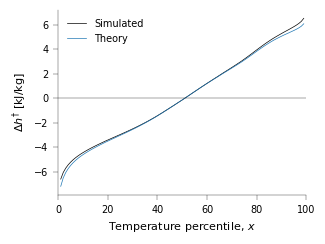

In [29]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax = [ax]
ax[0].plot(quant_plot, np.average(mse_mod_anom[0], weights=lat_weights, axis=0), color='k', label='Simulated')
ax[0].plot(quant_plot, np.average(mse_mod_anom0_theory, weights=lat_weights, axis=0), color=default_colors[0], label='Theory')
ax[0].legend()
ax[0].set_ylabel('$\Delta h^{\dagger}$ [kJ/kg]')
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)

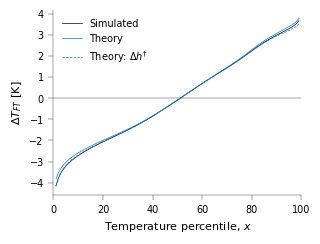

In [30]:
# Look how this new approximation affects the free troposphere temperature anomaly value
fig = copy.deepcopy(fig_temp_ft_anom)
ax = fig.axes
ax[0].plot(quant_plot, np.average(temp_ft_anom0_theory['ft6'], weights=lat_weights, axis=0), color=default_colors[0], linestyle='--', 
           label='Theory: $\Delta h^{\dagger}$')
ax[0].legend()
fig

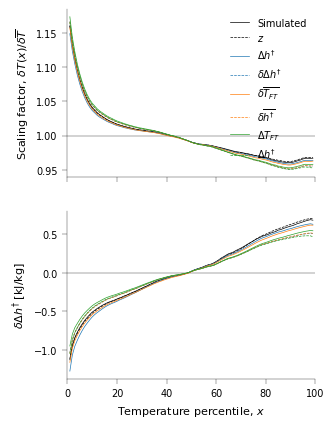

In [31]:
fig_approx6 = copy.deepcopy(fig_approx5)
ax = fig_approx6.axes
ax[0].plot(quant_plot, np.average(sf_theory['ft6'], weights=lat_weights, axis=0), color=default_colors[2], linestyle='--',
           label='$\Delta h^{\dagger}$')
ax[1].plot(quant_plot, np.average(mse_mod_anom_change_theory['ft6'], weights=lat_weights, axis=0), linestyle='--', color=default_colors[2])
ax[0].legend()
fig_approx6

# Surface Expansion of $\delta \Delta h^{\dagger}$
## Approx s1 - $\delta \Delta h^{\dagger}$
Here we do a non-linear expansion of $\delta h^{\dagger}(x)$ and $\delta \overline{h^{\dagger}}$ to obtain an expression for $\delta \Delta h^{\dagger}(x)$.

From Approx FT4, we have: 
$\delta \overline{h^{\dagger}} \approx \overline{\beta_{s1}}(1+\overline{\mu}\frac{\delta\overline{r_s}}{\overline{r_s}})\delta \overline{T_s} + 
L_v \overline{q_s^*}\delta \overline{r_s} - \delta \overline{\epsilon}$

Similarly, we have: $\delta h^{\dagger}(x) \approx \beta_{s1}(x)(1+\mu(x)\frac{\delta r_s(x)}{r_s(x)})\delta T_s(x) + 
L_v q_s^*(x)\delta r_s(x) - \delta \epsilon(x)$

In [32]:
mse_mod_quant_change_t_s_approx = {'s1': np.zeros((n_lat, n_quant))}
for i in range(n_lat):
    mse_mod_quant_change_t_s_approx['s1'][i] = mse_mod_change_surf_expansion(temp_quant3[:, ind_surf, i], sphum_quant3[:, i], 
                                                                             epsilon_quant3[:, i], p_surface, pressure_ft_actual,
                                                                             taylor_terms='non_linear')[0]
mse_mod_anom_change_theory['s1'] = mse_mod_quant_change_t_s_approx['s1'] - mse_mod_mean_change_t_s_approx['ft4'][:, np.newaxis]

sf_theory['s1'] = np.zeros((n_lat, n_quant))
for i in range(n_lat):
    for j in range(n_quant):
        sf_theory['s1'][i, j] = scipy.optimize.fsolve(scale_factor_theory_from_mse_anom_change_fit_func, 1, 
                                  args=(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i, j], r_mean[:, i], 
                                        r_quant3[:, i, j], epsilon_mean[:, i], epsilon_quant3[:, i, j], mse_mod_anom_change_theory['s1'][i, j]))

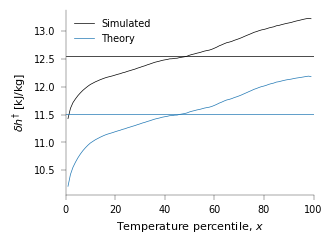

In [33]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average(mse_mod_quant3[1]-mse_mod_quant3[0], axis=0, weights=lat_weights), color='k', label='Simulated')
ax.axhline(np.average(mse_mod_mean[1]-mse_mod_mean[0], axis=0, weights=lat_weights), color='k')
ax.plot(quant_plot, np.average(mse_mod_quant_change_t_s_approx['s1'], axis=0, weights=lat_weights), color=default_colors[0], label='Theory')
ax.axhline(np.average(mse_mod_mean_change_t_s_approx['ft4'], axis=0, weights=lat_weights), color=default_colors[0])
ax.set_ylabel('$\delta h^{\dagger}$ [kJ/kg]')
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)
ax.legend()

(0.0, 100.0)

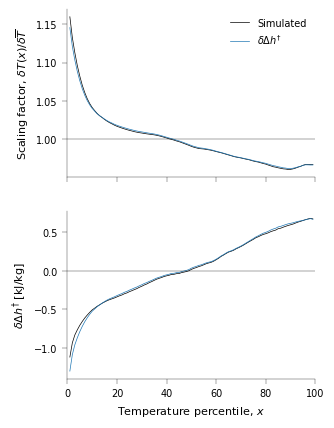

In [34]:
fig_approx_s1, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
ax[0].plot(quant_plot, np.average(sf_simulated, weights=lat_weights, axis=0), color='k',
           label='Simulated')
ax[0].plot(quant_plot, np.average(sf_theory['s1'], weights=lat_weights, axis=0), color=default_colors[0], label='$\delta \Delta h^{\dagger}$')
ax[1].plot(quant_plot, np.average(mse_mod_anom_change_simulated, axis=0, weights=lat_weights), color='k')
ax[1].plot(quant_plot, np.average(mse_mod_anom_change_theory['s1'], axis=0, weights=lat_weights), color=default_colors[0])
ax[0].legend()
ax[0].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
ax[1].set_ylabel('$\delta \Delta h^{\dagger}$ [kJ/kg]')
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)

## Approx s2 - $q^*_s(x)$
We can approximate $q^*_s(x) \approx \overline{q^*_s}(1+\overline{\alpha_s}\Delta T_s(x))$ re-write $\delta r_s(x)$ such that:

$q^*_s(x)\delta r_s(x) - \overline{q^*_s}\delta \overline{r_s} \approx \overline{q^*_s}\overline{\alpha_s}\Delta T_s(x)\delta \overline{r_s} + 
\overline{q^*_s}(1+\overline{\alpha_s}\Delta T_s(x))\delta \Delta \overline{r_s}$

In [35]:
humidity_mse_anom_change_term = (L_v * sphum_quant3[0]/r_quant3[0] * (r_quant3[1]-r_quant3[0]) - 
                                 (L_v * q_sat_s * (r_mean[1] - r_mean[0]))[:, np.newaxis])/1000
humidity_mse_anom_change_term_theory_breakdown = {'r_anom': L_v * q_sat_s[:, np.newaxis] * (r_anom[1]-r_anom[0])/1000, 
                                                  'r_mean': L_v * q_sat_s[:, np.newaxis] * 
                                                            (alpha_s * (r_mean[1] - r_mean[0]))[:, np.newaxis]*temp_anom[0, ind_surf]/1000,
                                                  'r_anom_temp_anom': L_v * q_sat_s[:, np.newaxis] * alpha_s[:, np.newaxis]*temp_anom[0, ind_surf] * 
                                                             (r_anom[1]-r_anom[0])/1000}
humidity_mse_anom_change_term_theory = humidity_mse_anom_change_term_theory_breakdown['r_anom']+\
                                       humidity_mse_anom_change_term_theory_breakdown['r_anom_temp_anom']+\
                                       humidity_mse_anom_change_term_theory_breakdown['r_mean']
q_sat_s_x_theory = q_sat_s[:, np.newaxis]*(1+alpha_s[:, np.newaxis] * temp_anom[0, ind_surf])
mse_mod_quant_change_t_s_approx['s2'] =  np.zeros((n_lat, n_quant))
for i in range(n_lat):
    mse_mod_quant_change_t_s_approx['s2'][i] = mse_mod_change_surf_expansion(temp_quant3[:, ind_surf, i], sphum_quant3[:, i], 
                                                                             epsilon_quant3[:, i], p_surface, pressure_ft_actual,
                                                                             taylor_terms='non_linear', 
                                                                             q_sat_s_linear_term_use=q_sat_s_x_theory[i])[0]
mse_mod_anom_change_theory['s2'] = mse_mod_quant_change_t_s_approx['s2'] - mse_mod_mean_change_t_s_approx['ft4'][:, np.newaxis]

sf_theory['s2'] = np.zeros((n_lat, n_quant))
for i in range(n_lat):
    for j in range(n_quant):
        sf_theory['s2'][i, j] = scipy.optimize.fsolve(scale_factor_theory_from_mse_anom_change_fit_func, 1, 
                                  args=(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i, j], r_mean[:, i], 
                                        r_quant3[:, i, j], epsilon_mean[:, i], epsilon_quant3[:, i, j], mse_mod_anom_change_theory['s2'][i, j]))

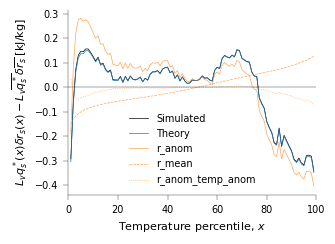

In [36]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average(humidity_mse_anom_change_term, axis=0, weights=lat_weights), color='k', label='Simulated')
ax.plot(quant_plot, np.average(humidity_mse_anom_change_term_theory, axis=0, weights=lat_weights), color=default_colors[0], label='Theory')
linestyles_breakdown = ['-', '--', ':']
for i, key in enumerate(humidity_mse_anom_change_term_theory_breakdown):
    ax.plot(quant_plot, np.average(humidity_mse_anom_change_term_theory_breakdown[key], axis=0, weights=lat_weights), 
            color=default_colors[1], label=key, linestyle=linestyles_breakdown[i], alpha=0.7)
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_ylabel('$L_v q_s^*(x)\delta r_s(x) - L_v\overline{q_s^*}\delta \overline{r_s}$ [kJ/kg]')
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)
ax.legend()

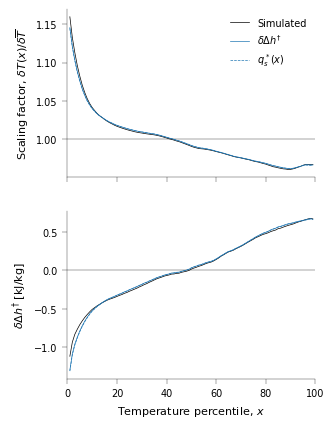

In [37]:
fig_approx_s2 = copy.deepcopy(fig_approx_s1)
ax = fig_approx_s2.axes
ax[0].plot(quant_plot, np.average(sf_theory['s2'], weights=lat_weights, axis=0), color=default_colors[0], linestyle='--',
           label='$q_s^*(x)$')
ax[1].plot(quant_plot, np.average(mse_mod_anom_change_theory['s2'], weights=lat_weights, axis=0), linestyle='--', color=default_colors[0])
ax[0].legend()
fig_approx_s2

## Approx s3 - $\beta_{s1}(x)$
To get an equation for $\delta T_s(x)$, we must divide through by $\beta_{s1}(x)$, hence we need an approximation for $\beta_{s1}(x)^{-1}$:

$$
\begin{align}
\begin{split}
\frac{\overline{\beta_{s1}}}{\beta_{s1}(x)} = \left(1 + \frac{\Delta \beta_{s1}(x)}{\overline{\beta_{s1}}}\right)^{-1} 
&\approx 1 - \frac{\Delta \beta_{s1}(x)}{\overline{\beta_{s1}}}\\
&\approx 1 - 
\frac{\overline{\beta_{s2}}}{\overline{\beta_{s1}}}\left(1 + \frac{\Delta r_s(x)}{\overline{r_s}}\right)\frac{\Delta T_s(x)}{\overline{T_s}} - 
\frac{L_v \overline{\alpha_s}\overline{q_s}}{\overline{\beta_{s1}}}\frac{\Delta r_s(x)}{\overline{r_s}}
\end{split}
\end{align}
$$

In [38]:
_, _, _, beta_s1_x, _, _ = get_theory_prefactor_terms(temp_quant3[0, ind_surf], p_surface, pressure_ft_actual, sphum_quant3[0])
beta_s1_ratio_theory_breakdown = {'temp': -(beta_s2/beta_s1/temp_mean[0, ind_surf])[:, np.newaxis] * temp_anom[0, ind_surf], 
                                  'humidity': -(L_v*alpha_s*q_sat_s/beta_s1)[:, np.newaxis]*r_anom[0]}
beta_s1_ratio_theory_breakdown['temp_humidity'] = beta_s1_ratio_theory_breakdown['temp'] * r_anom[0]/r_mean[0, :, np.newaxis]
beta_s1_ratio_theory = 1+beta_s1_ratio_theory_breakdown['temp'] + beta_s1_ratio_theory_breakdown['humidity'] + \
                       beta_s1_ratio_theory_breakdown['temp_humidity']
beta_s1_x_theory = beta_s1[:, np.newaxis]/beta_s1_ratio_theory

mse_mod_quant_change_t_s_approx['s3'] =  np.zeros((n_lat, n_quant))
for i in range(n_lat):
    mse_mod_quant_change_t_s_approx['s3'][i] = mse_mod_change_surf_expansion(temp_quant3[:, ind_surf, i], sphum_quant3[:, i], 
                                                                             epsilon_quant3[:, i], p_surface, pressure_ft_actual,
                                                                             taylor_terms='non_linear', 
                                                                             q_sat_s_linear_term_use=q_sat_s_x_theory[i], 
                                                                             beta_s1_use=beta_s1_x_theory[i])[0]
mse_mod_anom_change_theory['s3'] = mse_mod_quant_change_t_s_approx['s3'] - mse_mod_mean_change_t_s_approx['ft4'][:, np.newaxis]

sf_theory['s3'] = np.zeros((n_lat, n_quant))
for i in range(n_lat):
    for j in range(n_quant):
        sf_theory['s3'][i, j] = scipy.optimize.fsolve(scale_factor_theory_from_mse_anom_change_fit_func, 1, 
                                  args=(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i, j], r_mean[:, i], 
                                        r_quant3[:, i, j], epsilon_mean[:, i], epsilon_quant3[:, i, j], mse_mod_anom_change_theory['s3'][i, j]))

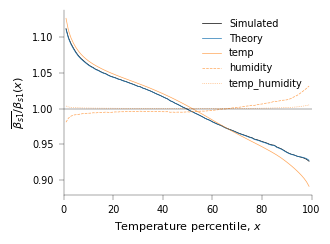

In [39]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average(beta_s1[:, np.newaxis]/beta_s1_x, axis=0, weights=lat_weights), color='k', label='Simulated')
ax.plot(quant_plot, np.average(beta_s1_ratio_theory, axis=0, weights=lat_weights), color=default_colors[0], label='Theory')
for i, key in enumerate(beta_s1_ratio_theory_breakdown):
    ax.plot(quant_plot, 1+np.average(beta_s1_ratio_theory_breakdown[key], axis=0, weights=lat_weights), 
            color=default_colors[1], label=key, linestyle=linestyles_breakdown[i], alpha=0.7)
ax.axhline(1, color='k', lw=ax_linewidth)
ax.set_ylabel('$\overline{\\beta_{s1}}/\\beta_{s1}(x)$')
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)
ax.legend()

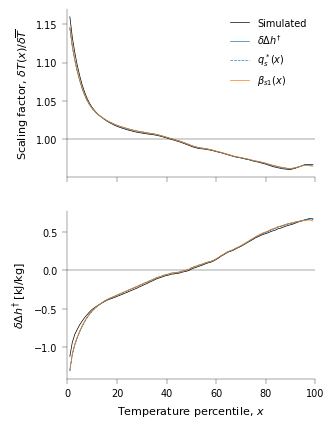

In [40]:
fig_approx_s3 = copy.deepcopy(fig_approx_s2)
ax = fig_approx_s3.axes
ax[0].plot(quant_plot, np.average(sf_theory['s3'], weights=lat_weights, axis=0), color=default_colors[1],
           label='$\\beta_{s1}(x)$')
ax[1].plot(quant_plot, np.average(mse_mod_anom_change_theory['s3'], weights=lat_weights, axis=0), color=default_colors[1])
ax[0].legend()
fig_approx_s3

## Approx s4 - $\overline{\beta_{s1}}$
When divide through by $\beta_{s1}(x)$ to get equation for $\delta T_s(x)$, replace with $\overline{\beta_{s1}}$, except where it appears with the leading $\left(1+\overline{\mu}\frac{\delta \overline{r_s}}{\overline{r_s}}\right)\delta \overline{T_s}$ term.


In [41]:
mse_mod_quant_change_t_s_approx['s4'] =  np.zeros((n_lat, n_quant))
for i in range(n_lat):
    mse_mod_quant_change_t_s_approx['s4'][i] = mse_mod_change_surf_expansion(temp_quant3[:, ind_surf, i], sphum_quant3[:, i], 
                                                                             epsilon_quant3[:, i], p_surface, pressure_ft_actual,
                                                                             taylor_terms='non_linear', 
                                                                             q_sat_s_linear_term_use=q_sat_s_x_theory[i], 
                                                                             beta_s1_use=beta_s1[i])[0]
mse_mod_mean_change_t_s_approx['s4'] = np.zeros((n_lat, n_quant))
for i in range(n_lat):
    for j in range(n_quant):
        mse_mod_mean_change_t_s_approx['s4'][i, j] = \
            mse_mod_change_surf_expansion(temp_mean[:, ind_surf, i], sphum_mean[:, i], epsilon_mean[:, i], p_surface, pressure_ft_actual, 
                                          taylor_terms='non_linear', beta_s1_use=beta_s1[i] * beta_s1_ratio_theory[i, j])[0]
mse_mod_anom_change_theory['s4'] = mse_mod_quant_change_t_s_approx['s4'] - mse_mod_mean_change_t_s_approx['s4']

sf_theory['s4'] = np.zeros((n_lat, n_quant))
for i in range(n_lat):
    for j in range(n_quant):
        sf_theory['s4'][i, j] = scipy.optimize.fsolve(scale_factor_theory_from_mse_anom_change_fit_func, 1, 
                                  args=(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i, j], r_mean[:, i], 
                                        r_quant3[:, i, j], epsilon_mean[:, i], epsilon_quant3[:, i, j], mse_mod_anom_change_theory['s4'][i, j]))

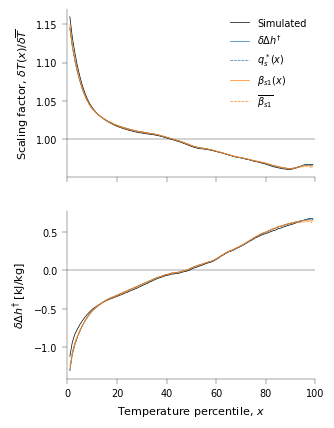

In [42]:
fig_approx_s4 = copy.deepcopy(fig_approx_s3)
ax = fig_approx_s4.axes
ax[0].plot(quant_plot, np.average(sf_theory['s4'], weights=lat_weights, axis=0), color=default_colors[1], linestyle='--',
           label='$\overline{\\beta_{s1}}$')
ax[1].plot(quant_plot, np.average(mse_mod_anom_change_theory['s4'], weights=lat_weights, axis=0), color=default_colors[1], linestyle='--')
ax[0].legend()
fig_approx_s4

# Combining $\delta \Delta h^{\dagger}(x)$ approximations to give $\delta T_s(x)$

In [43]:
sf_theory['final'] = np.zeros((n_lat, n_quant))
for i in range(n_lat):
    for j in range(n_quant):
        sf_theory['final'][i, j] = scipy.optimize.fsolve(scale_factor_theory_taylor_fit_func, 1, 
                                                     args=(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i, j], r_mean[:, i], 
                                                           r_quant3[:, i, j], epsilon_mean[:, i], epsilon_quant3[:, i, j], 
                                                           mse_mod_anom_change_theory['ft6'][i, j],'non_linear', p_surface, pressure_ft_actual, 
                                                           q_sat_s_x_theory[i, j], beta_s1[i], beta_s1[i] * beta_s1_ratio_theory[i, j]))

/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_84867/1170762301.py:71: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  temp_surf_quant_use = np.asarray([temp_surf_quant[0], temp_surf_quant[0] + scale_factor * temp_mean_change], dtype=np.float64)


(0.0, 100.0)

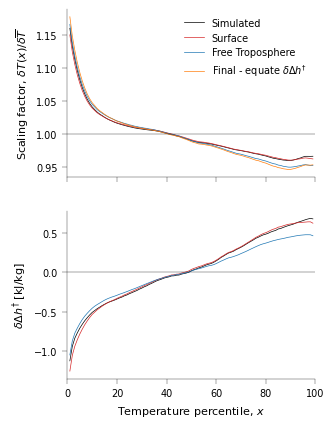

In [44]:
fig_final1, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
ax[0].plot(quant_plot, np.average(sf_simulated, weights=lat_weights, axis=0), color='k',
           label='Simulated')
ax[0].plot(quant_plot, np.average(sf_theory['s4'], weights=lat_weights, axis=0), color=default_colors[3], label='Surface')
ax[0].plot(quant_plot, np.average(sf_theory['ft6'], weights=lat_weights, axis=0), color=default_colors[0], label='Free Troposphere')
ax[0].plot(quant_plot, np.average(sf_theory['final'], weights=lat_weights, axis=0), color=default_colors[1], 
           label='Final - equate $\delta \Delta h^{\dagger}$')
ax[1].plot(quant_plot, np.average(mse_mod_anom_change_simulated, axis=0, weights=lat_weights), color='k')
ax[1].plot(quant_plot, np.average(mse_mod_anom_change_theory['s4'], axis=0, weights=lat_weights), color=default_colors[3])
ax[1].plot(quant_plot, np.average(mse_mod_anom_change_theory['ft6'], axis=0, weights=lat_weights), color=default_colors[0])
ax[0].legend()
ax[0].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
ax[1].set_ylabel('$\delta \Delta h^{\dagger}$ [kJ/kg]')
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)

In [45]:
sf_theory_from_eqn = {'t_ft': np.zeros((n_lat, n_quant))}
for j in range(n_lat):
    sf_theory_from_eqn['t_ft'][j] = get_scaling_factor_theory(temp_mean[:, ind_surf, j], temp_quant3[:, ind_surf, j], sphum_mean[:, j], 
                                                               sphum_quant3[:, j], p_surface, pressure_ft_actual, 
                                                               temp_mean[:, ind_ft, j], temp_quant3[:, ind_ft, j], z_mean[:, ind_ft, j], 
                                                               z_quant3[:, ind_ft, j], non_linear=True)

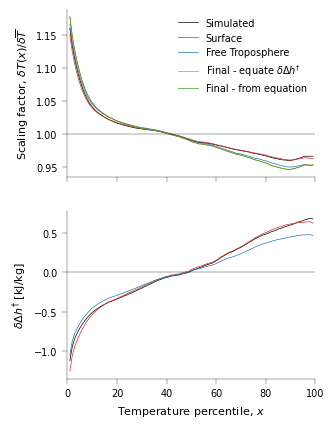

In [46]:
fig_final2 = copy.deepcopy(fig_final1)
ax = fig_final2.axes
ax[0].plot(quant_plot, np.average(sf_theory_from_eqn['t_ft'], weights=lat_weights, axis=0), color=default_colors[2],
           label='Final - from equation')
ax[0].legend()
fig_final2

## $z$ Form of Theory
Here, we replace the $\delta \Delta T_{FT}(x)$ term with $\delta \Delta z_{FT}(x)$.

In [47]:
def scale_factor_theory_from_mse_anom_change_z_theory_fit_func(scale_factor, temp_surf_mean, temp_surf_quant, r_surf_mean, r_surf_quant,
                                                               epsilon_mean, epsilon_quant, temp_ft_mean, z_surf_anom, z_ft_anom, 
                                                               mse_mod_mean_change, temp_ft_anom0,
                                                               pressure_surf: float = p_surface, pressure_ft = pressure_ft_actual):
    # mse_mod_anom_change is in kJ/kg
    n_exp = len(r_surf_mean)
    temp_mean_change = temp_surf_mean[1] - temp_surf_mean[0]
    temp_quant_hot = temp_surf_quant[0] + scale_factor * temp_mean_change
    mse_mod_surf_quant_cold = moist_static_energy(temp_surf_quant[0], r_surf_quant[0] * sphum_sat(temp_surf_quant[0], pressure_surf), 0,
                                              c_p_const=c_p - lnp_const) - epsilon_quant[0]
    mse_mod_surf_quant_hot = moist_static_energy(temp_quant_hot, r_surf_quant[1] * sphum_sat(temp_quant_hot, pressure_surf), 0, 
                                             c_p_const=c_p - lnp_const) - epsilon_quant[1]
    mse_mod_surf_mean = [moist_static_energy(temp_surf_mean[i], r_surf_mean[i] * sphum_sat(temp_surf_mean[i], pressure_surf), 0, 
                                         c_p_const=c_p - lnp_const) - epsilon_mean[i]
                     for i in range(n_exp)]
    mse_mod_anom_change_from_sf = mse_mod_surf_quant_hot - mse_mod_surf_quant_cold - (mse_mod_surf_mean[1] - mse_mod_surf_mean[0])
    
    temp_ft_anom_from_z_cold = g/lnp_const * (z_ft_anom[0] - z_surf_anom[0]) - (temp_surf_quant[0]-temp_surf_mean[0])
    temp_ft_anom_from_z_hot = g/lnp_const * (z_ft_anom[1] - z_surf_anom[1]) - (temp_quant_hot-temp_surf_mean[1])
    temp_quant_ft_from_z = np.asarray([temp_ft_mean[0]+temp_ft_anom_from_z_cold, temp_ft_mean[1]+temp_ft_anom_from_z_hot], dtype=np.float64)
    mse_mod_anom_change_from_ft = mse_mod_anom_change_ft_expansion(temp_ft_mean, temp_quant_ft_from_z[:, np.newaxis], p_surface, 
                                                                   pressure_ft, taylor_terms='linear', 
                                                                   mse_mod_mean_change=mse_mod_mean_change, 
                                                                   temp_ft_anom0=temp_ft_anom0)[0]
    
    return mse_mod_anom_change_from_sf - mse_mod_anom_change_from_ft

def scale_factor_theory_taylor_fit_z_theory_func(scale_factor, temp_surf_mean, temp_surf_quant, r_surf_mean, r_surf_quant, 
                                                 epsilon_mean, epsilon_quant, temp_ft_mean, z_surf_anom, z_ft_anom, 
                                                 mse_mod_mean_change_for_ft_expansion, temp_ft_anom0, taylor_terms='linear', 
                                                 pressure_surf = p_surface, pressure_ft=pressure_ft_actual, q_sat_s_linear_term_use=None,
                                                 beta_s1_quant_use=None, beta_s1_mean_use=None):
    # Makes same taylor series approximation for both ways of getting mse_anom_change
    # mse_mod_anom_change_from_temp_ft needs to be in kJ/kg
    temp_mean_change = temp_surf_mean[1] - temp_surf_mean[0]
    temp_surf_quant_use = np.asarray([temp_surf_quant[0], temp_surf_quant[0] + scale_factor * temp_mean_change], dtype=np.float64)
    
    sphum_mean = r_surf_mean * sphum_sat(temp_surf_mean, pressure_surf)
    sphum_quant = r_surf_quant * sphum_sat(temp_surf_quant_use, pressure_surf)
    
    mse_quant_change_from_temp_s = mse_mod_change_surf_expansion(temp_surf_quant_use[:, np.newaxis], sphum_quant[:, np.newaxis],
                                                                 epsilon_quant[:, np.newaxis], pressure_surf, pressure_ft, 
                                                                 taylor_terms=taylor_terms, q_sat_s_linear_term_use=q_sat_s_linear_term_use, 
                                                                 beta_s1_use=beta_s1_quant_use)[0]
    mse_mean_change_from_temp_s = mse_mod_change_surf_expansion(temp_surf_mean, sphum_mean, epsilon_mean,
                                                                pressure_surf, pressure_ft, taylor_terms=taylor_terms, 
                                                                beta_s1_use=beta_s1_mean_use)[0]
    mse_anom_change_from_temp_s = mse_quant_change_from_temp_s - mse_mean_change_from_temp_s
    
    temp_ft_anom_from_z = g/lnp_const * (z_ft_anom - z_surf_anom) - (temp_surf_quant_use-temp_surf_mean)
    temp_quant_ft_from_z = temp_ft_mean + temp_ft_anom_from_z
    mse_mod_anom_change_from_ft = mse_mod_anom_change_ft_expansion(temp_ft_mean, temp_quant_ft_from_z[:, np.newaxis], p_surface, 
                                                               pressure_ft, taylor_terms='linear', 
                                                               mse_mod_mean_change=mse_mod_mean_change_for_ft_expansion, 
                                                               temp_ft_anom0=temp_ft_anom0)[0]
    
    return mse_mod_anom_change_from_ft - mse_anom_change_from_temp_s

In [48]:
# mse_mod_anom_change_theory['ft6_z'] = np.zeros((n_lat, n_quant))
sf_theory['ft6_z'] = np.zeros((n_lat, n_quant))
sf_theory['final_z'] = np.zeros((n_lat, n_quant))
sf_theory_from_eqn['z_ft'] = np.zeros((n_lat, n_quant))
for i in range(n_lat):
    sf_theory_from_eqn['z_ft'][i] = get_scaling_factor_theory(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i], sphum_mean[:, i],  
                                                                       sphum_quant3[:, i], p_surface, pressure_ft_actual, temp_mean[:, ind_ft, i], 
                                                                       temp_quant3[:, ind_ft, i], z_mean[:, ind_ft, i], z_quant3[:, ind_ft, i],
                                                              non_linear=True, z_form=True)
    for j in range(n_quant):
        sf_theory['ft6_z'][i, j] = scipy.optimize.fsolve(scale_factor_theory_from_mse_anom_change_z_theory_fit_func, 1, 
                                  args=(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i, j], r_mean[:, i], 
                                        r_quant3[:, i, j], epsilon_mean[:, i], epsilon_quant3[:, i, j], temp_mean[:, ind_ft, i], 
                                        z_anom[:, ind_surf, i, j], z_anom[:, ind_ft, i, j], mse_mod_mean_change_t_s_approx['ft4'][i]*1000, 
                                        temp_ft_anom0_theory['ft6'][i, j]))
        
        sf_theory['final_z'][i, j] = scipy.optimize.fsolve(scale_factor_theory_taylor_fit_z_theory_func, 1, 
                                                     args=(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i, j], r_mean[:, i], 
                                                           r_quant3[:, i, j], epsilon_mean[:, i], epsilon_quant3[:, i, j], 
                                                           temp_mean[:, ind_ft, i], z_anom[:, ind_surf, i, j], z_anom[:, ind_ft, i, j],
                                                           mse_mod_mean_change_t_s_approx['ft4'][i]*1000, temp_ft_anom0_theory['ft6'][i, j],
                                                           'non_linear', p_surface, pressure_ft_actual, 
                                                           q_sat_s_x_theory[i, j], beta_s1[i], beta_s1[i] * beta_s1_ratio_theory[i, j]))

/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_84867/2097108315.py:20: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  temp_quant_ft_from_z = np.asarray([temp_ft_mean[0]+temp_ft_anom_from_z_cold, temp_ft_mean[1]+temp_ft_anom_from_z_hot], dtype=np.float64)
/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_84867/2097108315.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  temp_surf_quant_use = np.asarray([temp_surf_quant[0], temp_surf_quant[0] + scale_factor * temp_mean_change], dtype=

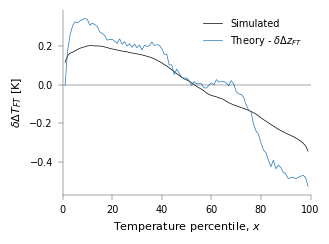

In [49]:
temp_ft_anom_from_z = g/lnp_const * (z_anom[:, ind_ft] - z_anom[:, ind_surf]) - temp_anom[:, ind_surf]

fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average(temp_anom[1, ind_ft]-temp_anom[0, ind_ft], axis=0, weights=lat_weights), color='k', label='Simulated')
ax.plot(quant_plot, np.average(temp_ft_anom_from_z[1] - temp_ft_anom_from_z[0], axis=0, weights=lat_weights),
        color=default_colors[0], label='Theory - $\delta \Delta z_{FT}$')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_ylabel('$\delta \Delta T_{FT}$ [K]')
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)
ax.legend()

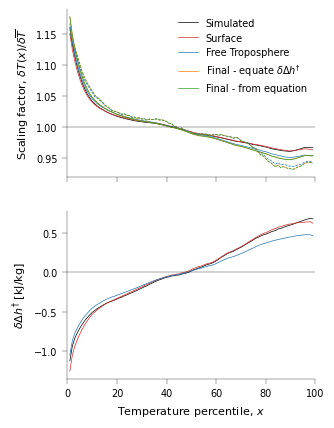

In [50]:
fig_final3 = copy.deepcopy(fig_final2)
ax = fig_final3.axes
ax[0].plot(quant_plot, np.average(sf_theory['ft6_z'], weights=lat_weights, axis=0), color=default_colors[0], linestyle='--')
ax[0].plot(quant_plot, np.average(sf_theory['final_z'], weights=lat_weights, axis=0), color=default_colors[1], linestyle='--')
ax[0].plot(quant_plot, np.average(sf_theory_from_eqn['z_ft'], weights=lat_weights, axis=0), color=default_colors[2], linestyle='--')
ax[0].legend()
fig_final3

## Use Adiabatic Temperature to compute $\gamma$ factors
It is preferable to use $\overline{T_A}$ rather than $\overline{T_{FT}}$ to compute the $\gamma$ factors, as then it only depends on two surface variables: $\overline{T_s}$ and $\overline{r_s}$. Here, we see how this approximation affects our final theory.

These are shown by the think transparent green lines. Clearly, it is not a big approximation.

In [51]:
for key in ['t', 'z']:
    sf_theory_from_eqn[key+'_A'] = np.zeros((n_lat, n_quant))
    for i in range(n_lat):
        sf_theory_from_eqn[key+'_A'][i] = get_scaling_factor_theory(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i], 
                                                                             sphum_mean[:, i], sphum_quant3[:, i], p_surface, pressure_ft_actual, 
                                                                             temp_mean[:, ind_ft, i], temp_quant3[:, ind_ft, i], 
                                                                             z_mean[:, ind_ft, i], z_quant3[:, ind_ft, i],
                                                                    non_linear=True, z_form='z' in key, use_temp_adiabat=True)

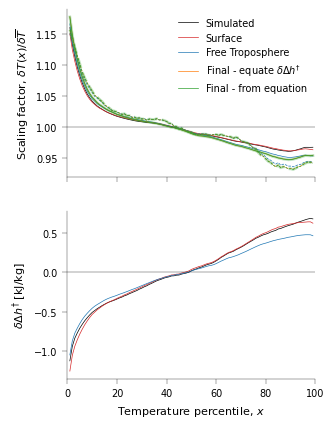

In [52]:
fig_final4 = copy.deepcopy(fig_final3)
ax = fig_final4.axes
ax[0].plot(quant_plot, np.average(sf_theory_from_eqn['t_A'], weights=lat_weights, axis=0), color=default_colors[2], alpha=0.3, lw=2)
ax[0].plot(quant_plot, np.average(sf_theory_from_eqn['z_A'], weights=lat_weights, axis=0), color=default_colors[2], linestyle='--', alpha=0.3, lw=2)
ax[0].legend()
fig_final4